In [1]:
import numpy as np
import pandas as pd

import sys
import os

# Absolute path to the utils directory
utils_path = os.path.abspath(r".\utils")

# Add it to sys.path
if utils_path not in sys.path:
    sys.path.append(utils_path)

In [2]:
# Necessary to not clog the output for pdf
import warnings
from scipy.sparse import SparseEfficiencyWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

In [3]:
# Loading the views

# Load all sheets from the Excel file
xls_path = r"..\Datasets\Final Datasets\subnationalindicatorsdataset.xlsx"
all_views = pd.read_excel(xls_path, sheet_name=None)

# Convert sheet names to lowercase keys and assign to variables
views = {}
for sheet_name, df in all_views.items():
    key = sheet_name.lower()
    views[key] = df
    globals()[f"{key}_df"] = df

# ONS replication

This uses the module ONS_implementation.py provided alongside this notebook. This module replicates the ONS Local Authority clustering methodology exactly as described in:
- https://www.ons.gov.uk/peoplepopulationandcommunity/wellbeing/methodologies/clusteringlocalauthoritiesagainstsubnationalindicatorsmethodology
- https://github.com/ONSdigital/Subnational-Statistics-and-Analysis/tree/main/clustering_and_nearest_neighbours

This assumes the dataset is already preprocessed to match the ONS structure, extracted from:
- https://www.ons.gov.uk/explore-local-statistics/indicators/gross-disposable-household-income-per-head (bottom of the page, under "accompanying dataset (ODS, 4MB))

(Please refer to our Datasets_Wrangling_LocalIndicators.ipynb for details on said preprocessing)

This also assumes you have access to the Clustered Local Authorities data from ONS, extracted from:
- https://www.ons.gov.uk/peoplepopulationandcommunity/wellbeing/datasets/clusteringlocalauthoritiesagainstsubnationalindicatorsengland

Key Features:
-------------
- Uses fixed k values as published by ONS
- Excludes specified Local Authority codes per view and labels them as Cluster = -1 as published by ONS
- Applies preprocessing: cleaning, winsorization, z-score standardization as published by ONS
- Applies PCA and KMeans with `variance_threshold=0.25` and `random_state=19042022` for reproducibility as published by ONS
- Visualises clustering structure using external plot_best_embedding()

Expected Input:
---------------
Each view is a DataFrame containing:
- 'Area Level'
- 'Area Code'
- 'Area'
- Several numeric indicator columns

## Single view approach


[economic] Running fixed-k clustering (k=4)


  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[economic] Silhouette = 0.372 on 307 areas


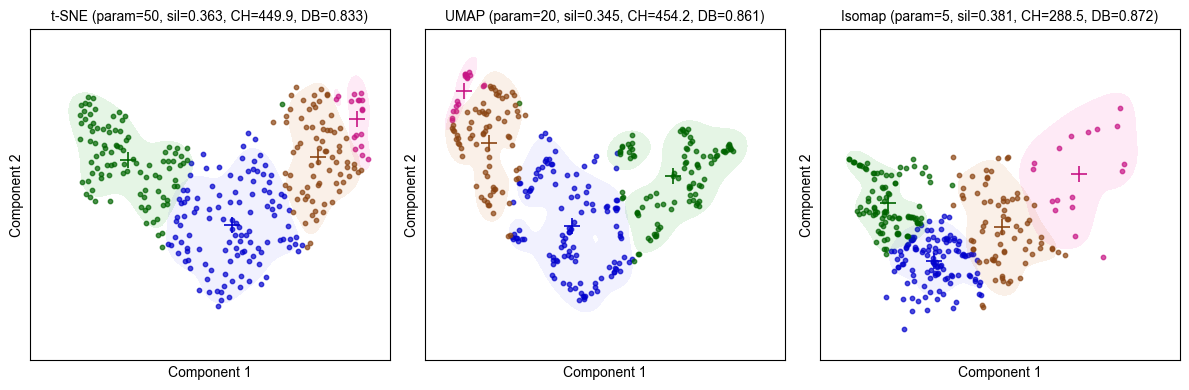

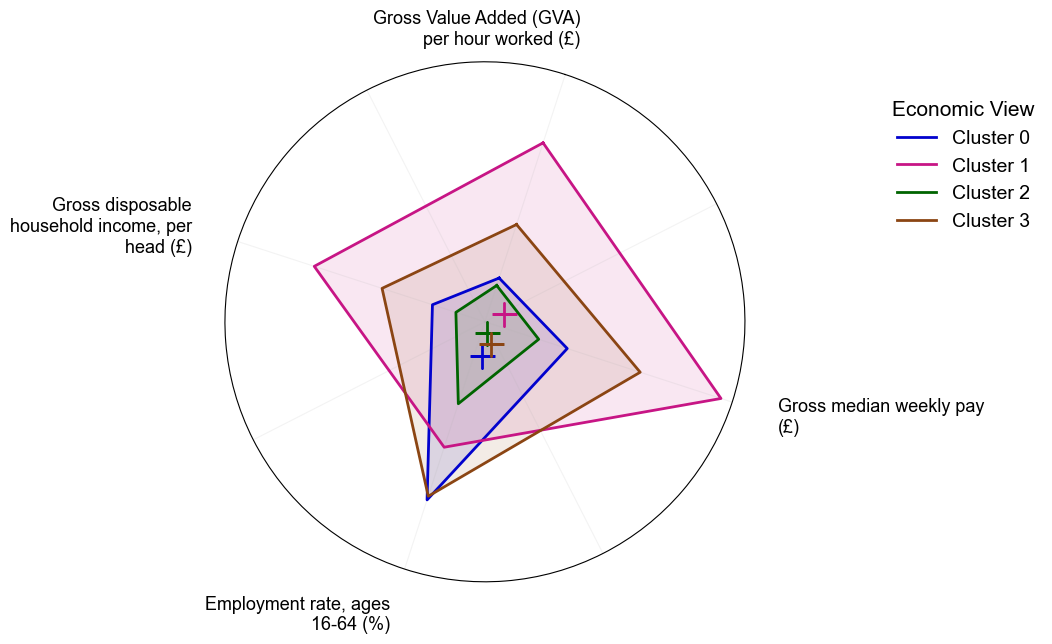


[connectivity] Running fixed-k clustering (k=4)
[connectivity] Silhouette = 0.508 on 295 areas


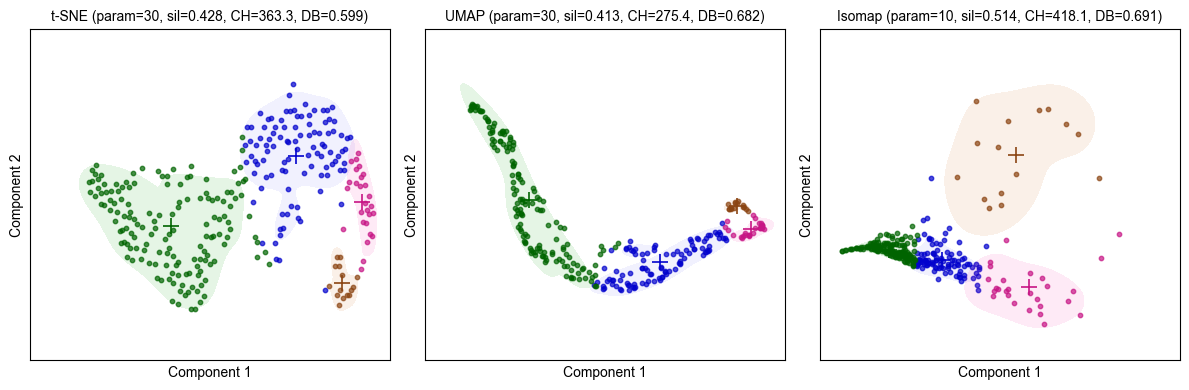

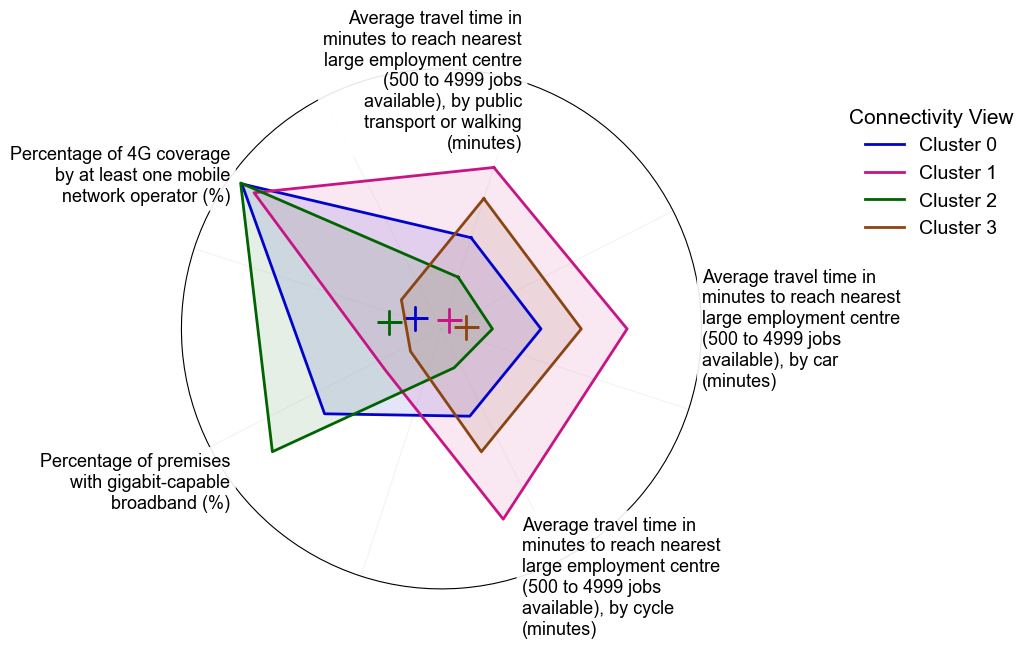


[educational_attainment] Running fixed-k clustering (k=8)
[educational_attainment] Silhouette = 0.384 on 122 areas


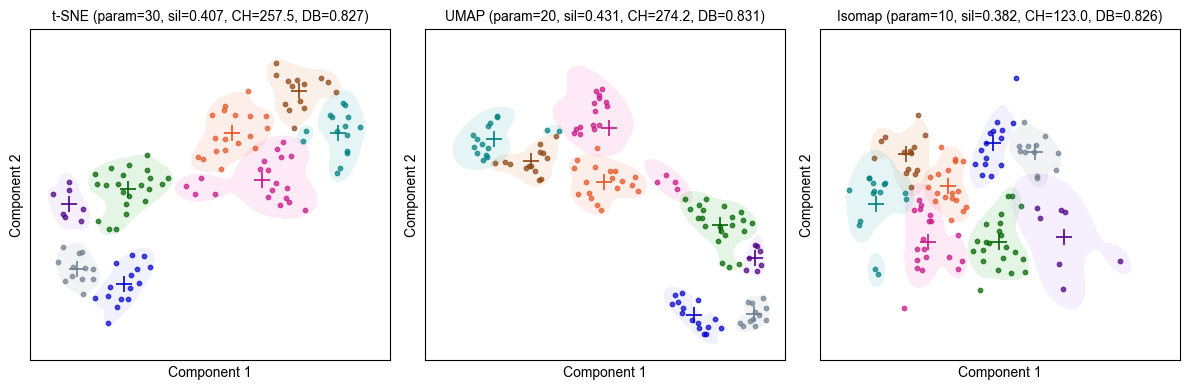

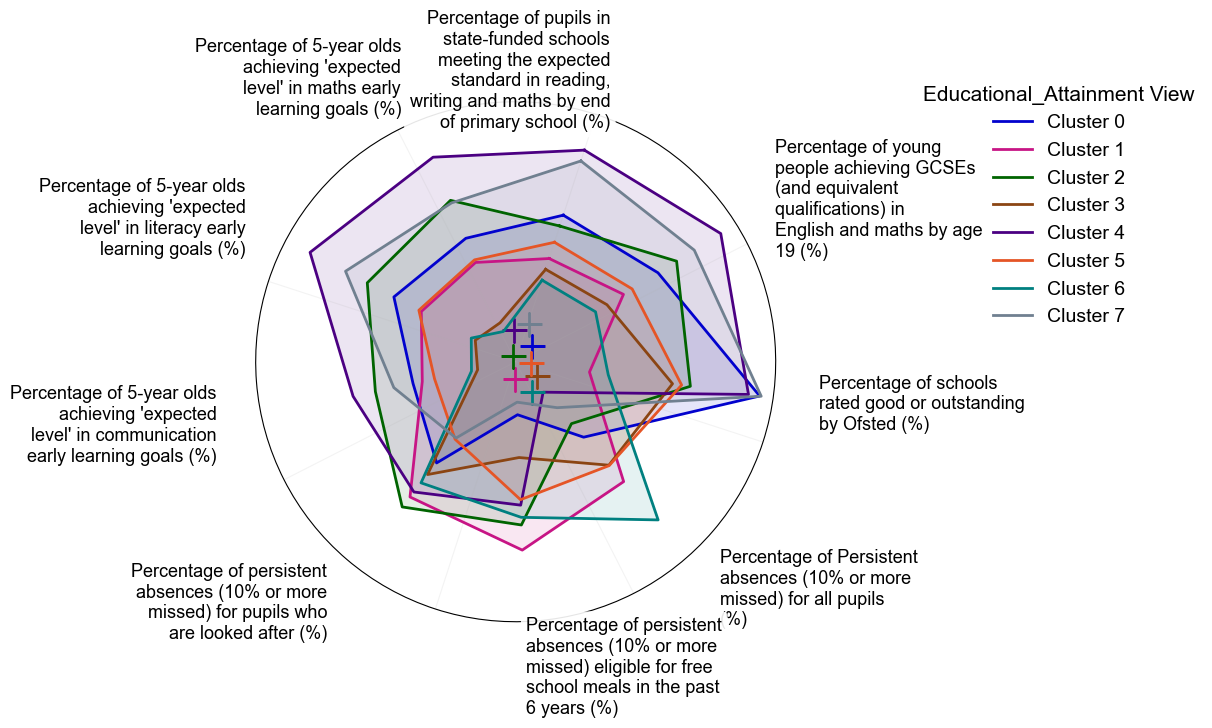


[skills] Running fixed-k clustering (k=4)
[skills] Silhouette = 0.374 on 307 areas


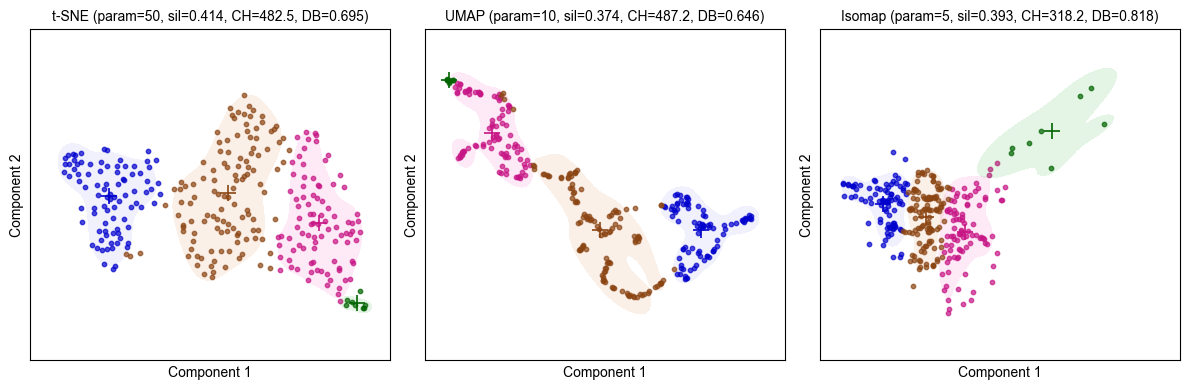

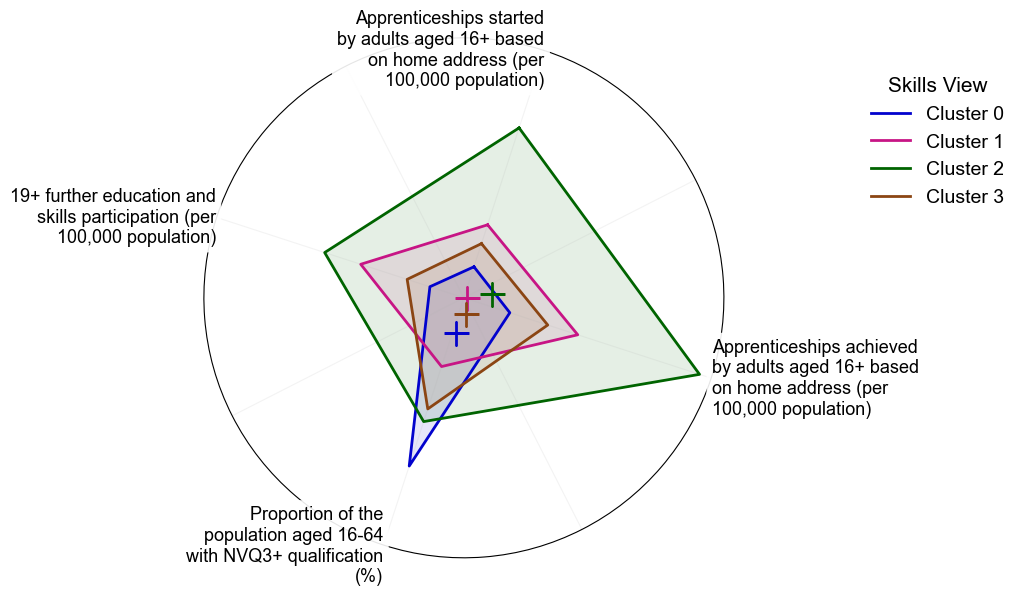


[health] Running fixed-k clustering (k=4)
[health] Silhouette = 0.418 on 86 areas


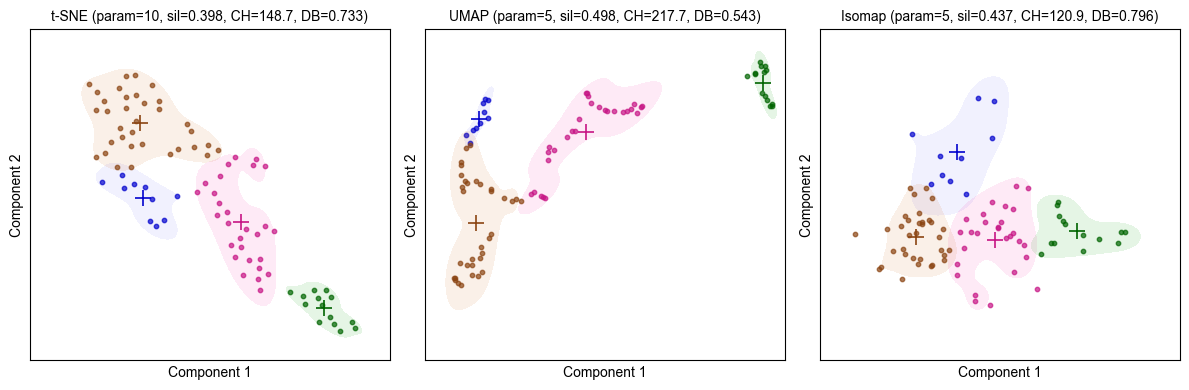

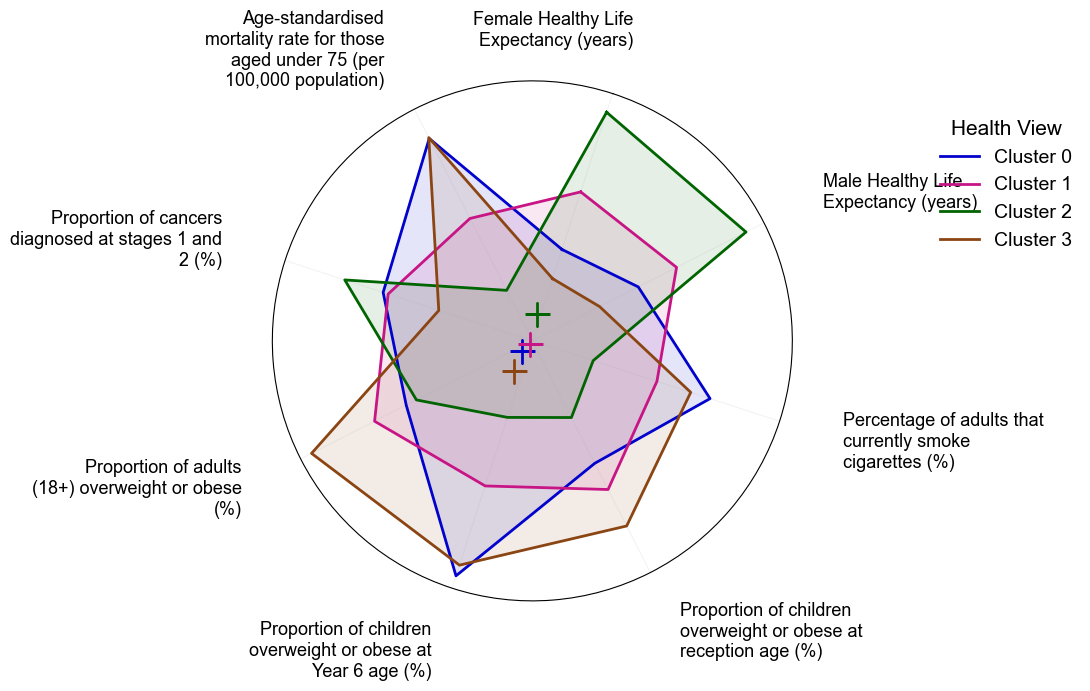


[wellbeing] Running fixed-k clustering (k=4)
[wellbeing] Silhouette = 0.325 on 305 areas


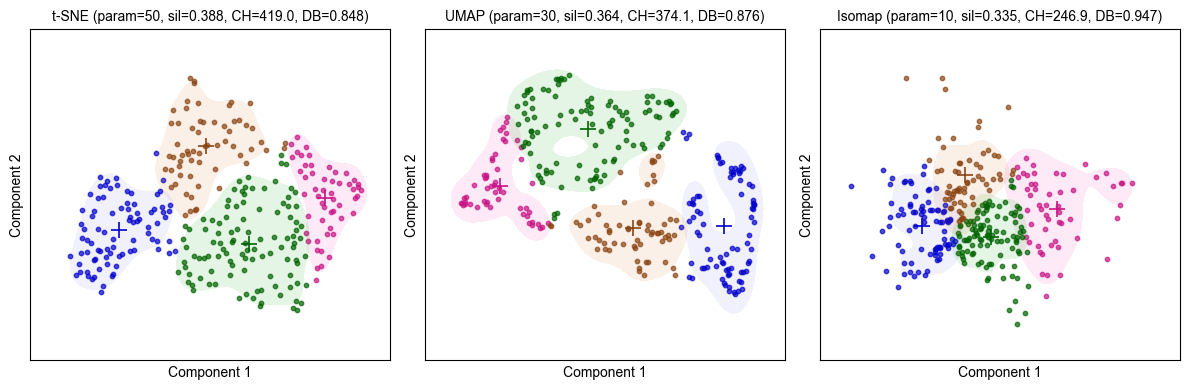

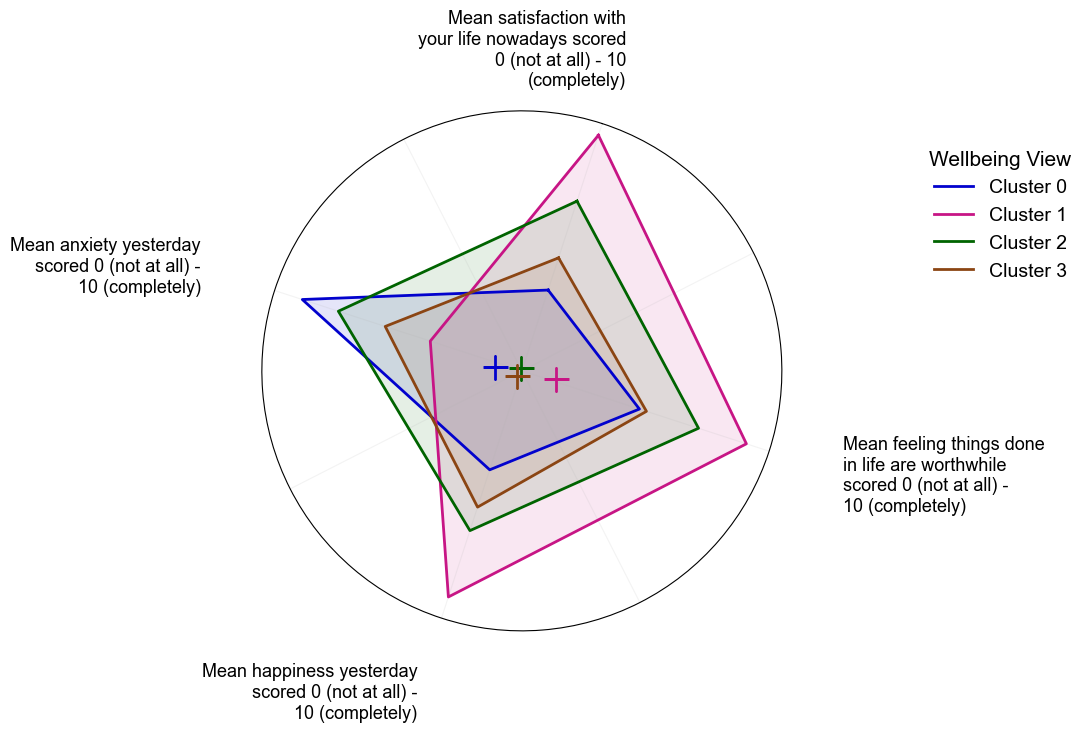

In [4]:
from ONS_implementation import run_ons_on_views

# Run the ONS clustering pipeline on the defined views
results_by_view, silhouette_scores_by_view = run_ons_on_views(
    views=views,
    variance_threshold=0.25, # to match ONS
    random_state=19042022, # to match ONS
    n_init=1000
)

## Early Integration for Headline model

[Headline] Silhouette = 0.426 | Excluded = 24


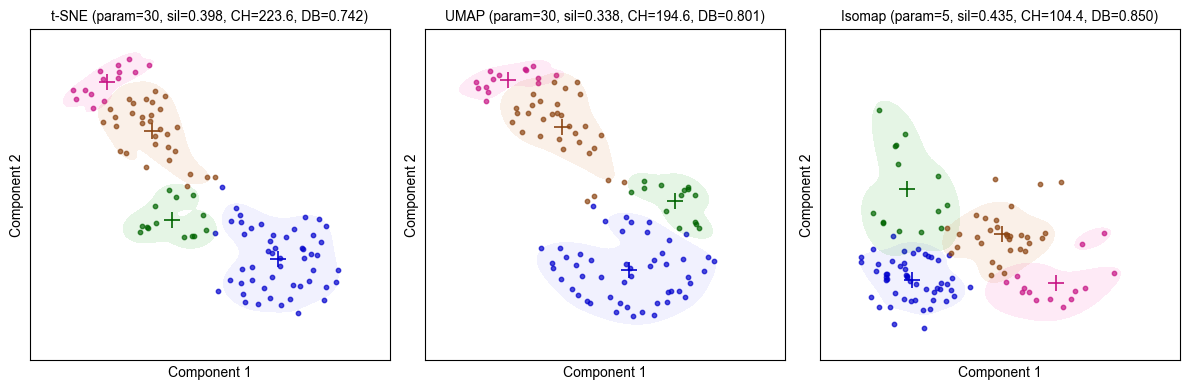

c:\Users\maxim\OneDrive\Education\MSc_MLDS_Imperial\Final Project - Multi-View Data Integration\Multi-View Clustering for Social Data\Notebooks\utils\plots_and_visualisations.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_df["Area Code"] = clusters_df["Area Code"].astype(str)


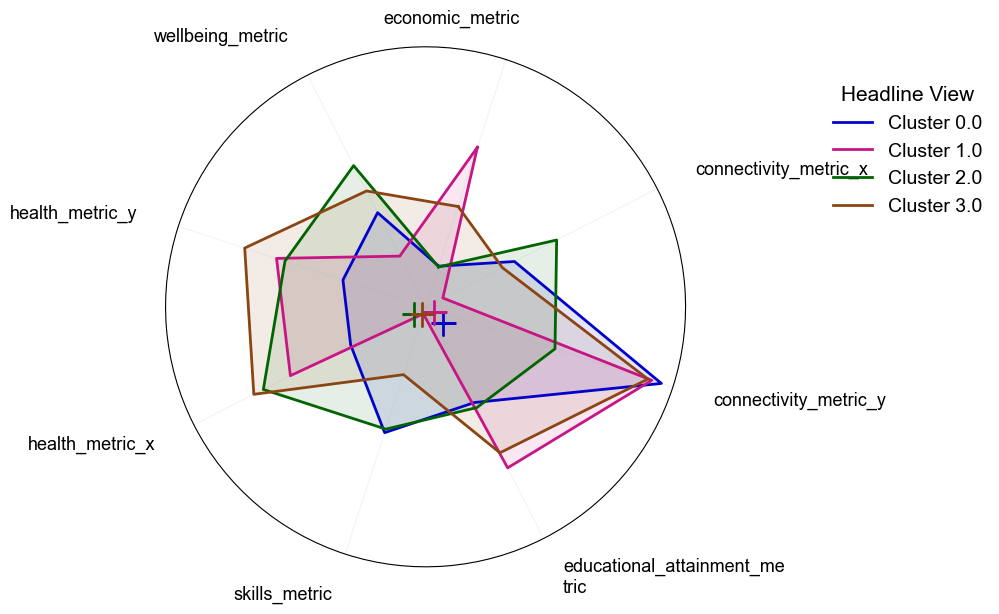

In [5]:
from ONS_implementation import run_ons_headline_model, ONS_EXCLUSIONS

# This is the list of selected metrics to match ONS
selected_metrics = [
    ('economic', 'Gross Value Added (GVA) per hour worked (£)'),
    ('connectivity', 'Average travel time in minutes to reach nearest large employment centre (500 to 4999 jobs available), by public transport or walking (minutes)'),
    ('connectivity', 'Percentage of premises with gigabit-capable broadband (%)'),
    ('educational_attainment', 'Percentage of pupils in state-funded schools meeting the expected standard in reading, writing and maths by end of primary school (%)'),
    ('skills', 'Apprenticeships achieved by adults aged 16+ based on home address (per 100,000 population)'),
    ('health', 'Female Healthy Life Expectancy (years)'),
    ('health', 'Male Healthy Life Expectancy (years)'),
    ('wellbeing', 'Mean satisfaction with your life nowadays scored 0 (not at all) - 10 (completely)')
]

exclusions = list(set(code for codes in ONS_EXCLUSIONS.values() for code in codes))

headline_df, headline_model, headline_sil, silhouette_scores = run_ons_headline_model(
    views=views,
    selected_metrics=selected_metrics, # to match ONS
    exclusions=exclusions, # to match ONS
    variance_threshold=0.25, # to match ONS
    random_state=19042022, # to match ONS
    n_init=1000,
    k=4, # to match ONS
    verbose=True
)

# Add results to the silhouette scores dictionary
silhouette_scores_by_view["headline"] = silhouette_scores

In [6]:
display(headline_df)

,Area Code,HeadlineCluster
0,E06000001,0
1,E06000002,0
2,E06000003,0
3,E06000004,0
4,E06000005,0
...,...,...
129,E09000029,3
130,E09000030,1
131,E09000031,3
132,E09000032,-1


## Export ONS replicated cluster labels

In [7]:
from ONS_implementation import export_cluster_labels

# Export combined cluster labels
all_cluster_labels = export_cluster_labels(results_by_view, headline_df)

# Preview or save
display(all_cluster_labels.head())
all_cluster_labels.to_csv("all_ons_cluster_labels.csv", index=False)

,Area Code,economic,connectivity,educational_attainment,skills,health,wellbeing,HeadlineCluster
0,E06000001,2.0,2.0,1.0,1.0,3.0,2.0,0.0
1,E06000002,2.0,0.0,3.0,1.0,3.0,3.0,0.0
2,E06000003,2.0,0.0,5.0,1.0,3.0,3.0,0.0
3,E06000004,2.0,2.0,2.0,1.0,1.0,0.0,0.0
4,E06000005,2.0,2.0,5.0,1.0,3.0,0.0,0.0


## Comparison between replicated and claimed clusters

In [8]:
ons_clusters_df = pd.read_csv(r"..\Datasets\Final Datasets\clusters_df.csv")

display(ons_clusters_df.head())

,Local_Authority_Code,Local_Authority_Name,Headline Model,Economic model,Connectivity model,Educational attainment model,Skills model,Health model,Well-being model,Headline Model Code,Economic model Code,Connectivity model Code,Educational attainment model Code,Skills model Code,Health model Code,Well-being model Code
0,E06000001,Hartlepool,"Higher connectivity, lower health and well-being",Below median on all economic metrics,Slightly below median on all connectivity metrics,"Higher KS2, lower GCSE performance",Above median apprenticeships and further educa...,Far below median on all health metrics,Slightly above median on all well-being metrics,0,0,0,0,0,0,0
1,E06000002,Middlesbrough,"Higher connectivity, lower health and well-being",Below median on all economic metrics,Slightly below median on all connectivity metrics,Lower on all education metrics,Above median apprenticeships and further educa...,Far below median on all health metrics,"Better than median anxiety, worse than median ...",0,0,0,1,0,0,1
2,E06000003,Redcar and Cleveland,"Higher connectivity, lower health and well-being",Below median on all economic metrics,Slightly below median on all connectivity metrics,"Lower on all metrics, except FSM and CLA absences",Above median apprenticeships and further educa...,Far below median on all health metrics,"Better than median anxiety, worse than median ...",0,0,0,2,0,0,1
3,E06000004,Stockton-on-Tees,"Higher connectivity, lower health and well-being",Below median on all economic metrics,Slightly below median on all connectivity metrics,"Higher KS2, lower GCSE performance",Above median apprenticeships and further educa...,Broadly median on all health metrics,Far below median on all well-being metrics,0,0,0,0,0,1,2
4,E06000005,Darlington,"Higher connectivity, lower health and well-being",Below median on all economic metrics,Far above median on all connectivity metrics,"Lower on all metrics, except FSM and CLA absences",Above median apprenticeships and further educa...,Far below median on all health metrics,Far below median on all well-being metrics,0,0,1,2,0,0,2


In [9]:
from ONS_implementation import compare_label_consistency

comparison_df = compare_label_consistency(all_cluster_labels, ons_clusters_df)
display(comparison_df)

,Model,Adjusted Rand Index,Normalized Mutual Information,Compared Pairs
0,Connectivity,0.538294,0.586162,294
1,Economic,0.781149,0.759021,307
2,Educational Attainment,0.319860,0.541645,122
3,Headlinecluster,0.626602,0.568611,110
4,Health,0.677282,0.713664,86
5,Skills,0.560684,0.567302,306
6,Wellbeing,0.576074,0.609588,305


## ONS Clusters Profiles

Generating radar plot for view: economic


c:\Users\maxim\OneDrive\Education\MSc_MLDS_Imperial\Final Project - Multi-View Data Integration\Multi-View Clustering for Social Data\Notebooks\utils\plots_and_visualisations.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_df["Area Code"] = clusters_df["Area Code"].astype(str)


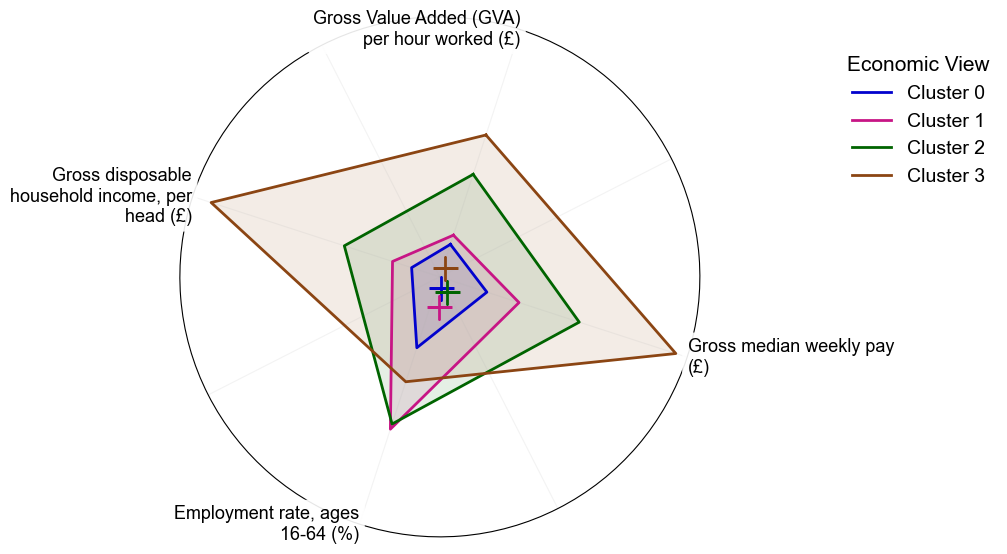

Generating radar plot for view: connectivity


c:\Users\maxim\OneDrive\Education\MSc_MLDS_Imperial\Final Project - Multi-View Data Integration\Multi-View Clustering for Social Data\Notebooks\utils\plots_and_visualisations.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_df["Area Code"] = clusters_df["Area Code"].astype(str)


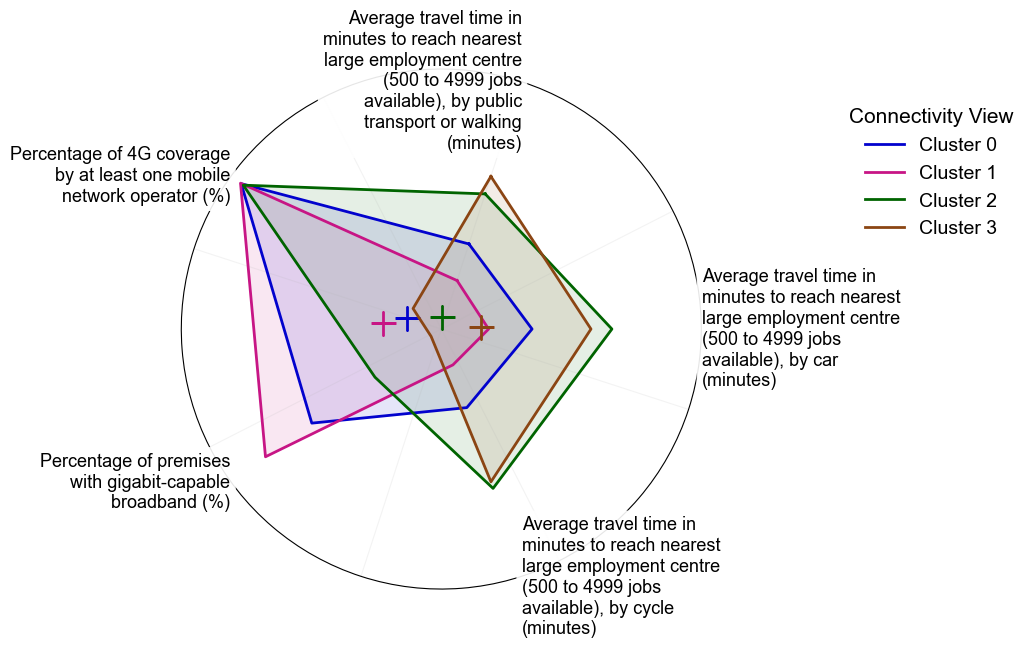

Generating radar plot for view: educational_attainment


c:\Users\maxim\OneDrive\Education\MSc_MLDS_Imperial\Final Project - Multi-View Data Integration\Multi-View Clustering for Social Data\Notebooks\utils\plots_and_visualisations.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_df["Area Code"] = clusters_df["Area Code"].astype(str)


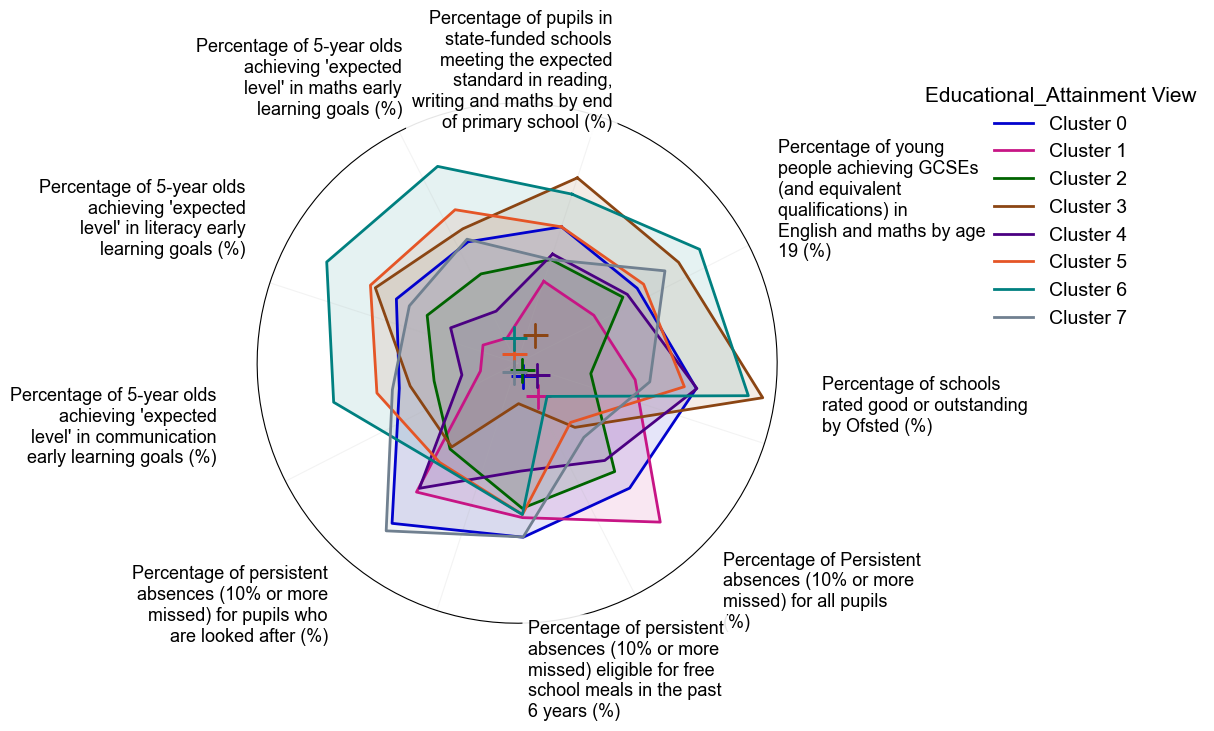

c:\Users\maxim\OneDrive\Education\MSc_MLDS_Imperial\Final Project - Multi-View Data Integration\Multi-View Clustering for Social Data\Notebooks\utils\plots_and_visualisations.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_df["Area Code"] = clusters_df["Area Code"].astype(str)


Generating radar plot for view: skills


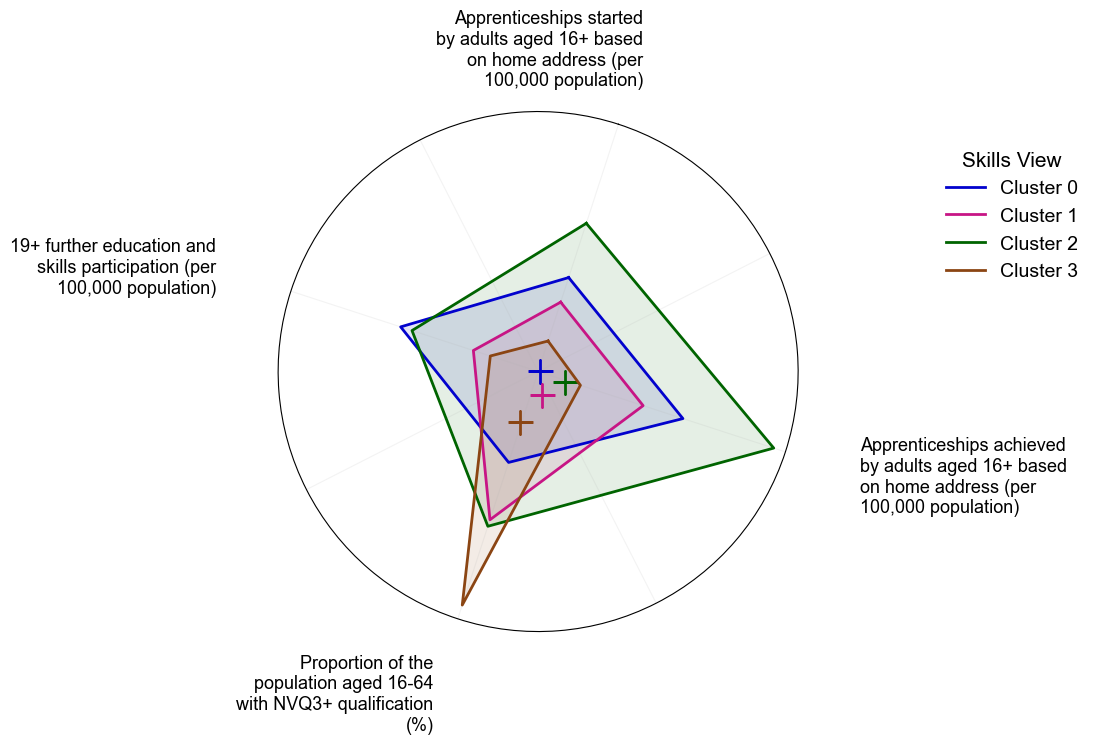

Generating radar plot for view: health


c:\Users\maxim\OneDrive\Education\MSc_MLDS_Imperial\Final Project - Multi-View Data Integration\Multi-View Clustering for Social Data\Notebooks\utils\plots_and_visualisations.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_df["Area Code"] = clusters_df["Area Code"].astype(str)


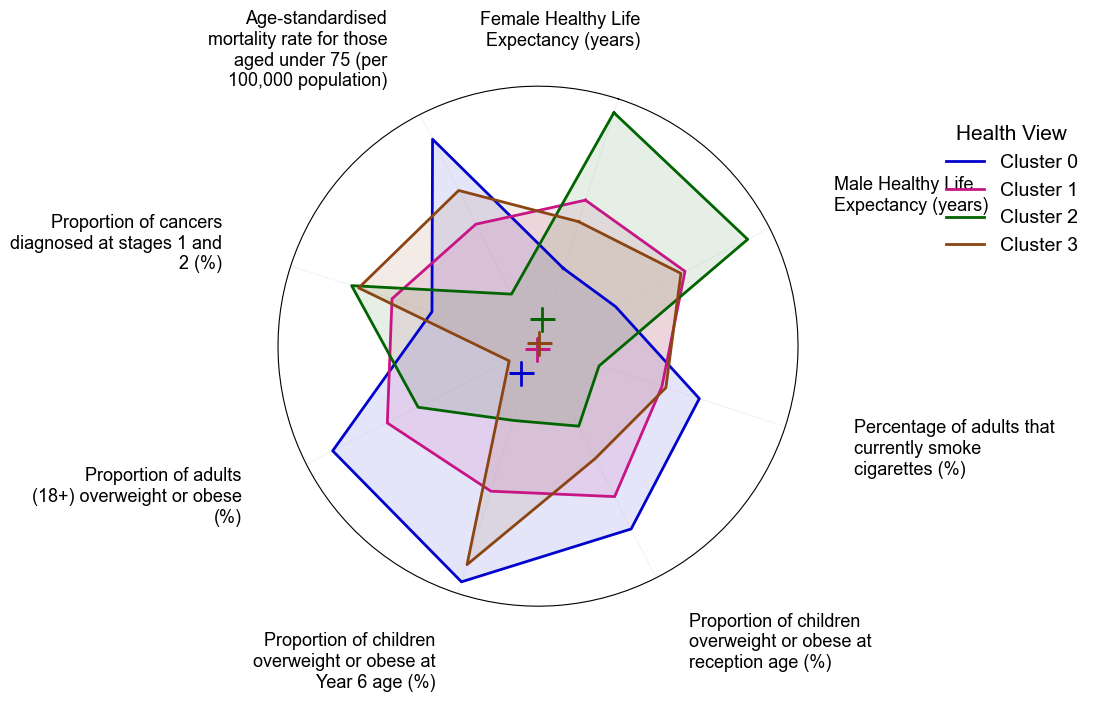

c:\Users\maxim\OneDrive\Education\MSc_MLDS_Imperial\Final Project - Multi-View Data Integration\Multi-View Clustering for Social Data\Notebooks\utils\plots_and_visualisations.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_df["Area Code"] = clusters_df["Area Code"].astype(str)


Generating radar plot for view: wellbeing


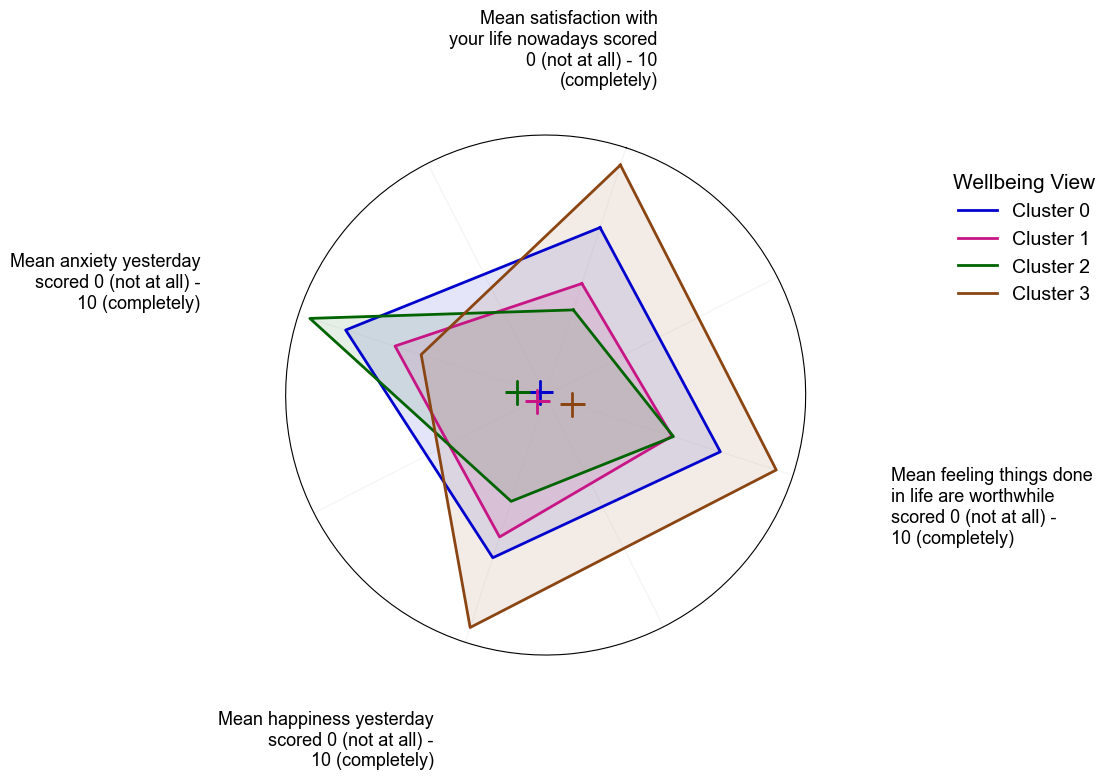

In [11]:
from plots_and_visualisations import radar_plot
from ONS_implementation import preprocess_view

# 1. Map view names to ONS cluster column names
ons_view_cluster_map = {
    "economic": "Economic model Code",
    "connectivity": "Connectivity model Code",
    "educational_attainment": "Educational attainment model Code",
    "skills": "Skills model Code",
    "health": "Health model Code",
    "wellbeing": "Well-being model Code"
}

# 2. Loop over each view
for view_name, ons_cluster_col in ons_view_cluster_map.items():
    print(f"Generating radar plot for view: {view_name}")

    # --- Step 3: Preprocess the view ---
    view_df = preprocess_view(views[view_name].copy(), view_name)

    # --- Step 4: Add the correct cluster assignment from ONS ---
    cluster_df = ons_clusters_df[["Local_Authority_Code", ons_cluster_col]].copy()
    cluster_df = cluster_df.rename(columns={
        "Local_Authority_Code": "Area Code",
        ons_cluster_col: "Cluster"
    })

    # Keep only Area Code and Cluster
    cluster_df = cluster_df[["Area Code", "Cluster"]]

    # Merge cleanly — view_df only has one "Area Code" column, so no _x/_y
    view_df = view_df.merge(cluster_df, on="Area Code", how="left")

    # --- Step 5: Drop missing or invalid clusters ---
    view_df = view_df.dropna(subset=["Cluster"])
    view_df = view_df[view_df["Cluster"] != -1]

    # --- Step 6: Plot radar chart ---
    radar_plot(
        view_name,
        {view_name: view_df},
        {view_name: {"clusters": view_df[["Area Code", "Cluster"]]}},
        preprocess_view=lambda x, _: x  # Already preprocessed
    )

## Intermediate Integration for Headline model

[Intermediate] Shared Area Codes across all views: 81
[economic] Latent space shape: (81, 2)
[connectivity] Latent space shape: (81, 2)
[educational_attainment] Latent space shape: (81, 2)
[skills] Latent space shape: (81, 2)
[health] Latent space shape: (81, 2)
[wellbeing] Latent space shape: (81, 2)
[spatial] Latent space shape: (81, 2)
[Intermediate] k = 4 | Silhouette = 0.191
[Intermediate] k = 5 | Silhouette = 0.200
[Intermediate] k = 6 | Silhouette = 0.170
[Intermediate] k = 7 | Silhouette = 0.160
[Intermediate] k = 8 | Silhouette = 0.153
[Intermediate] k = 9 | Silhouette = 0.151
[Intermediate] k = 10 | Silhouette = 0.139
[Intermediate] k = 11 | Silhouette = 0.148
[Intermediate] k = 12 | Silhouette = 0.156
[Intermediate] k = 13 | Silhouette = 0.151
[Intermediate] k = 14 | Silhouette = 0.141
[Intermediate] k = 15 | Silhouette = 0.148


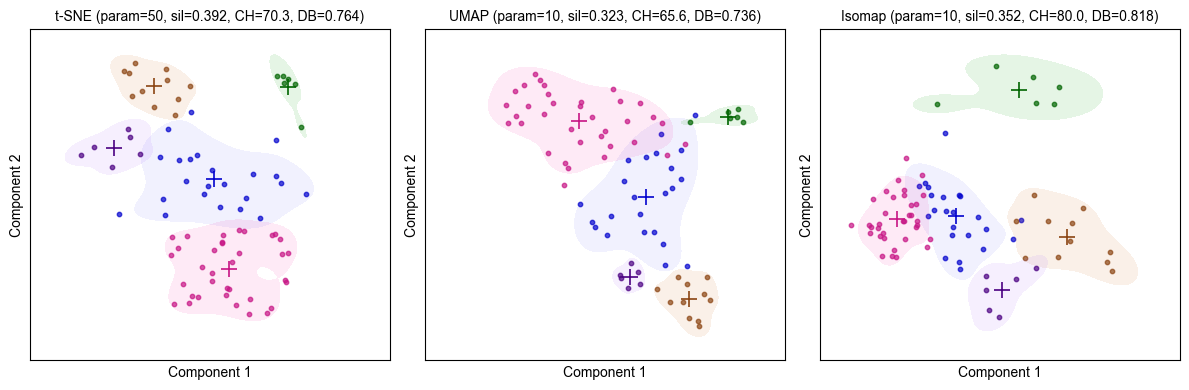

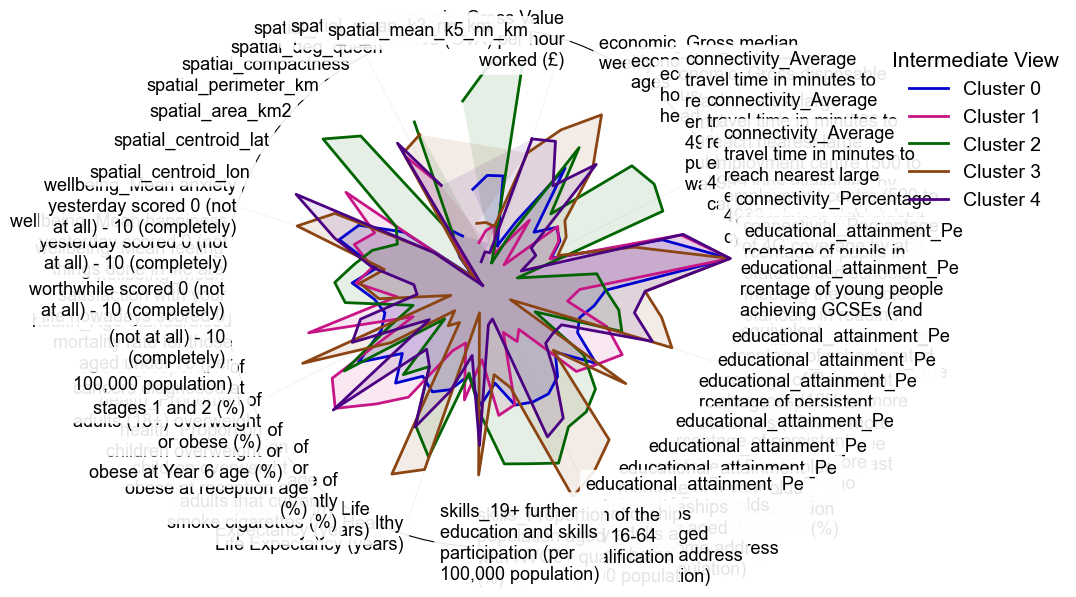

In [12]:
from ONS_implementation import run_ons_headline_model_intermediate

# Define parameters
pca_variance_threshold = 0.25 # to match ONS
k_range = range(4, 16) # to match ONS
random_state=19042022 # to match ONS
n_init = 1000

# Run intermediate integration (PCA per view, then concatenate, then KMeans)
headline_df_intermediate, best_model_intermediate, best_score_intermediate, silhouette_scores_intermediate = run_ons_headline_model_intermediate(
    views=views,
    variance_threshold=pca_variance_threshold,
    k_range=k_range,
    random_state=random_state,
    n_init=n_init
)

## Late integration for Headline Model

[Late Integration] Shared Area Codes: 81
[economic] k = 4 | Silhouette = 0.401
[economic] k = 5 | Silhouette = 0.396
[economic] k = 6 | Silhouette = 0.398
[economic] k = 7 | Silhouette = 0.401
[economic] k = 8 | Silhouette = 0.381
[economic] k = 9 | Silhouette = 0.403
[economic] k = 10 | Silhouette = 0.430
[economic] k = 11 | Silhouette = 0.432
[economic] k = 12 | Silhouette = 0.439
[economic] k = 13 | Silhouette = 0.437
[economic] k = 14 | Silhouette = 0.433
[economic] k = 15 | Silhouette = 0.437
[economic] Best k = 12 | Silhouette = 0.439
[connectivity] k = 4 | Silhouette = 0.401
[connectivity] k = 5 | Silhouette = 0.413
[connectivity] k = 6 | Silhouette = 0.418
[connectivity] k = 7 | Silhouette = 0.433
[connectivity] k = 8 | Silhouette = 0.461
[connectivity] k = 9 | Silhouette = 0.443
[connectivity] k = 10 | Silhouette = 0.444
[connectivity] k = 11 | Silhouette = 0.445
[connectivity] k = 12 | Silhouette = 0.424
[connectivity] k = 13 | Silhouette = 0.402
[connectivity] k = 14 | Silho

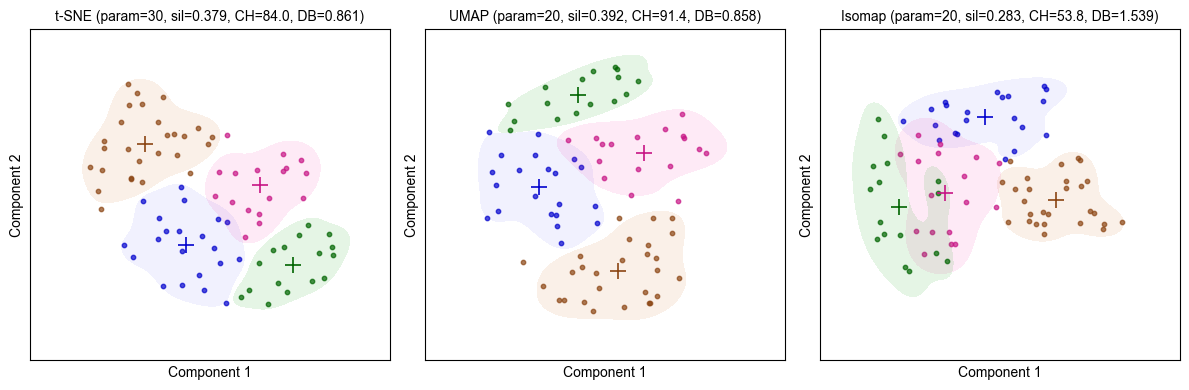

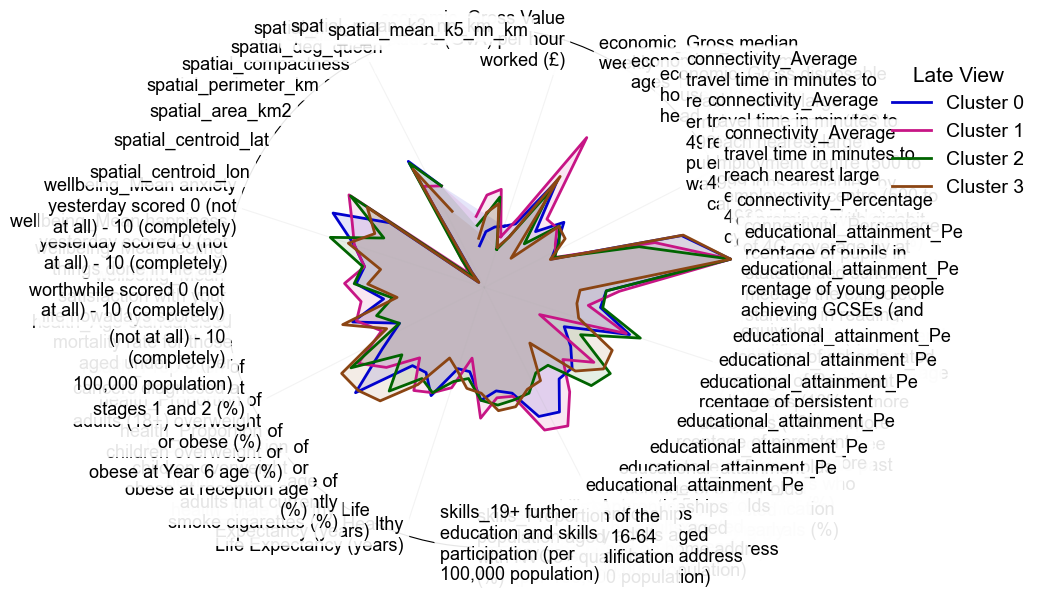

In [13]:
from ONS_implementation import run_ons_headline_model_late

# Parameters
k_range = range(4, 16)
random_state=19042022 # to match ONS
n_init = 1000 
pca_variance_threshold = 0.25 # to match ONS

# Run Late Integration
headline_df_late, best_k_late, best_score_late, silhouette_scores_late = run_ons_headline_model_late(
    views=views,
    k_range=k_range,
    random_state=random_state,
    n_init=n_init,
    variance_threshold=pca_variance_threshold,
    verbose=True
)

# Add results to silhouette scores tracker
silhouette_scores_by_view["headline_late"] = silhouette_scores_late

In [14]:
pd.DataFrame(silhouette_scores_late)

,economic,connectivity,educational_attainment,skills,health,wellbeing,spatial
4,0.401399,0.401199,0.378062,0.350182,0.419865,0.347235,0.464497
5,0.396013,0.412834,0.388973,0.365993,0.383113,0.363492,0.408233
6,0.397689,0.417670,0.379948,0.398501,0.356300,0.367937,0.405713
7,0.401259,0.433489,0.378411,0.411940,0.361109,0.382823,0.405404
8,0.380537,0.460954,0.387302,0.383210,0.363790,0.379285,0.371164
9,0.403374,0.442692,0.408029,0.371858,0.366790,0.397691,0.363087
10,0.430409,0.443672,0.420020,0.366348,0.378664,0.394424,0.369790
11,0.432125,0.444947,0.423027,0.379405,0.378376,0.404152,0.372942
12,0.439112,0.424457,0.426062,0.373996,0.370815,0.419399,0.373602
13,0.437448,0.401918,0.423139,0.383120,0.381270,0.425670,0.392680
